# DEEP LEARNING - MINI PROJECT

Name: Jonathan Hansen

Date: 03.01.25

### Housing Price Prediction with ANN and SOM:

Working with the Boston Housing dataset to predict home values. A SOM clusters neighborhoods with similar characteristics then feed those insights to an ANN. The insights from the SOM can provide additional context that refines the ANN’s predictive capabilities.

# Overview:
1. Data Processing
2. Implemented SOM
3. Map samples to Cluster Labels (via kmeans)
4. One-Hot Encoding the cluster labels
5. Implemented the ANN.

14 total columns in the Boston Housing Dataset

- CRIM - per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to ﬁve Boston employment centers
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per $10,000
- PTRATIO: pupil-teacher ratio by town 12.

- B:  1000(Bk−0.63)^2 where Bk is the proportion of blacks by town 13.

- LSTAT: - % lower status of the population

- MEDV: Median value of owner-occupied homes in $1000s

We can see that the input attributes have a mixture of units.

In [2]:
#pip install minisom

In [3]:
# Import Libraries and Packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# For the ANN using TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [4]:
# Column names
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Reading csv
df = pd.read_csv("housing.csv", header=None, delimiter=r"\s+", names=column_names)

# Viewing loaded data
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Data Processing

In [5]:
# Checking data info types and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
# There are no nulls seen in the info above
df = df.dropna()

In [7]:
# Getting columns
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

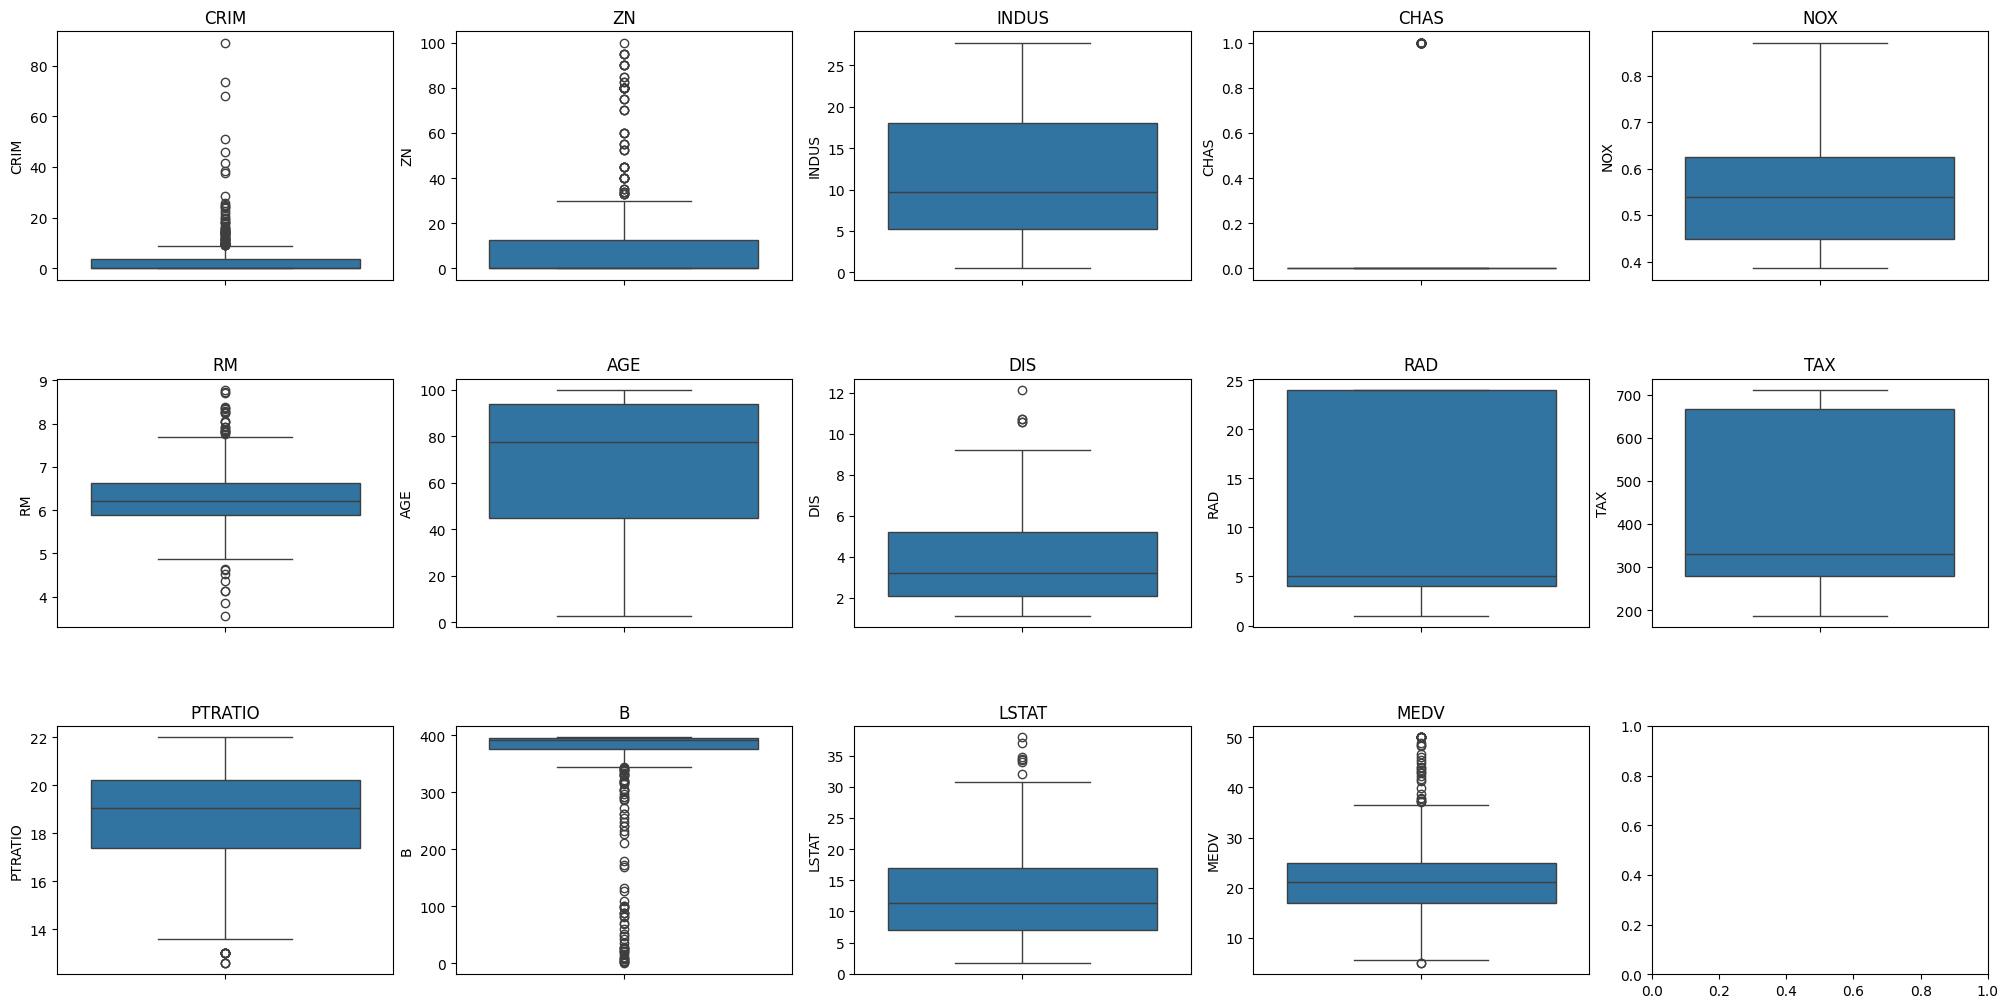

In [8]:
# Printing the box plot for each feature
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10))
axs = axs.flatten()
for index, (col, values) in enumerate(df.items()):
    sns.boxplot(y=col, data=df, ax=axs[index])
    axs[index].set_title(col)  # add the column name as the title
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()


In [9]:
# Tried with and without outliers and got better results not removing the outliers. 
# This could be possible if the outliers are representative of the actual variablity of the data.

# Set your threshold (commonly 1.5 for outlier detection)
# threshold = 3

# Start with a mask that is True for every row
mask = pd.Series(True, index=df.index)

# # Iterate over each column and update the mask
# for col in df.columns:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - threshold * IQR
#     upper_bound = Q3 + threshold * IQR
    
#     # Update the mask: row must be within the bounds for this column
#     mask &= df[col].between(lower_bound, upper_bound)

# Apply the mask to filter the DataFrame
df_new = df[mask].copy()


Originally set the threshold to 1.5, but this removed half of the overall rows. So adjusted this to 3. After running models will check this to see what effect it has on the outputs.

In [10]:
# Printing how many rows were removed from original dataset
print("Original shape:", df.shape)
print("New shape:", df_new.shape)

Original shape: (506, 14)
New shape: (506, 14)


In [11]:
# Splitting the data into feature and target
X = df_new.drop(columns='MEDV').values
y = df_new['MEDV'].values

In [12]:
# Split into training and testing sets
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# # Scaling using Standard Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test  = scaler.transform(X_test_1)

# Implementing SOM

In [14]:
# Can adjust this parameter to potentially allow the model to capture more detail in the data
som_grid_rows, som_grid_cols = 7, 7  

# Initialize the SOM
som = MiniSom(x=som_grid_rows, 
              y=som_grid_cols, 
              input_len=X_train.shape[1], 
              sigma=1.0, 
              learning_rate=0.5, 
              random_seed=42)

# Initialize weights and train the SOM
som.random_weights_init(X_train)
print("Training SOM...")
som.train_random(data=X_train, num_iteration=1000)
print("SOM training completed.")

Training SOM...
SOM training completed.


In [15]:
# Extracting the SOM codebook vectors
# Shape will be (som_grid_rows, som_grid_cols, input_dim)
codebook_vectors = som.get_weights()

# Rashaping the vectors
# Flatten the grid into shape (num_neurons, input_dim)
codebook_vectors_reshaped = codebook_vectors.reshape(
    som_grid_rows * som_grid_cols, 
    X_train.shape[1]
)

# Defining number of clusters
n_clusters = 4 

# Kmeans 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(codebook_vectors_reshaped)

# Assigning neurons in the SOM a cluster label
# We'll reshape the cluster labels back to (som_grid_rows, som_grid_cols)
neuron_labels = kmeans.labels_.reshape(som_grid_rows, som_grid_cols)

# Map samples to Cluster Labels

In [16]:
def map_sample_to_cluster(som_model, sample, neuron_labels):
    # Finding the Best Matching Unit
    winner = som_model.winner(sample)
    # Returning the cluster label for neuron
    return neuron_labels[winner[0], winner[1]]

# Maping training samples
train_clusters = np.array([
    map_sample_to_cluster(som, sample, neuron_labels) 
    for sample in X_train])

# Mapping the test samples
test_clusters = np.array([
    map_sample_to_cluster(som, sample, neuron_labels) 
    for sample in X_test])


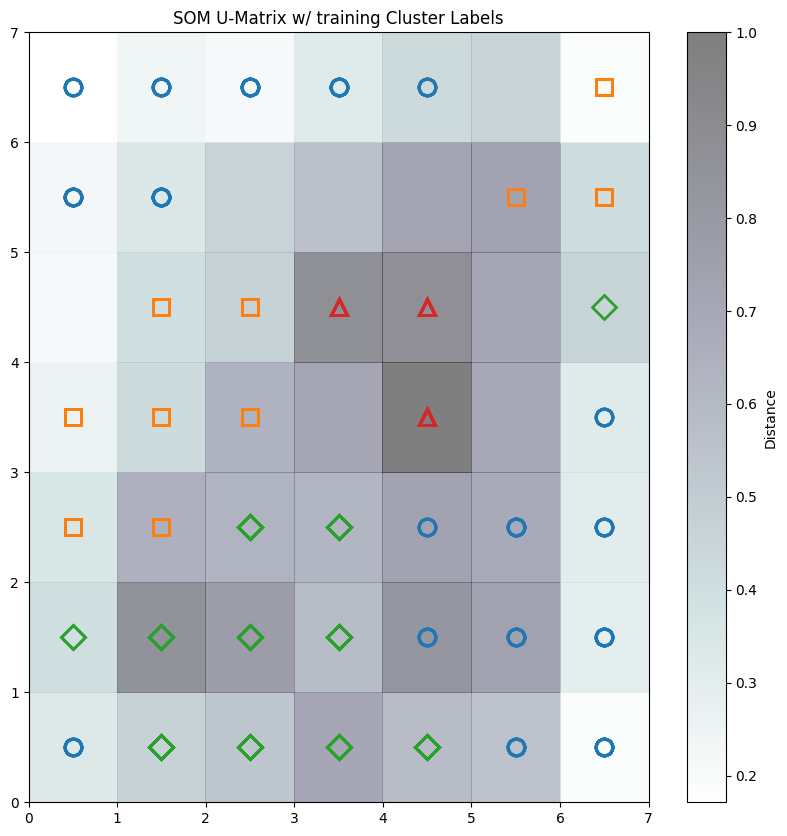

In [21]:
import matplotlib.pyplot as plt

# visualizing the U-Matrix
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=0.5)
plt.colorbar(label='Distance')
plt.title("SOM U-Matrix w/ training Cluster Labels")

# Defining the markers and a colormap for clusters (adjust for more clusters)
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

# Plotting each training sample on the SOM grid
for i, sample in enumerate(X_train):
    bmu = som.winner(sample)  # Get BMU coordinates (row, col)
    cluster = map_sample_to_cluster(som, sample, neuron_labels)
    # Offset by 0.5 so that markers are centered in the cell
    plt.plot(bmu[1] + 0.5, bmu[0] + 0.5, 
             marker=markers[cluster % len(markers)], 
             markerfacecolor='None', 
             markeredgecolor=colors[cluster % len(colors)], 
             markersize=12, 
             markeredgewidth=2)

plt.xlim([0, som_grid_cols])
plt.ylim([0, som_grid_rows])
plt.gca()
plt.show()


This visualization shows use neighborhood groupings. So areas with similar characteristics are grouped together. Squares in the top left corner all have similar neighborhood. Lighter panels in the SOM indicate groupings that are more similar indicating more similar data and darker panels indicate groupings that are boundries where the neurons differ more significantly. While the shapes in each panel are created by the kmeans clustering. Clustering similar panels into like groupings.

# One-Hot Encoding the Cluster Labels

In [18]:
# One hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_clusters_enc = encoder.fit_transform(train_clusters.reshape(-1, 1))
test_clusters_enc  = encoder.transform(test_clusters.reshape(-1, 1))

# Combine scaled features with cluster label features
X_train_final = np.concatenate([X_train, train_clusters_enc], axis=1)
X_test_final  = np.concatenate([X_test, test_clusters_enc], axis=1)

# Pritning the shape of training and test data
print("Shape training data:", X_train_final.shape)
print("Shape test data:", X_test_final.shape)


Shape training data: (404, 17)
Shape test data: (102, 17)


# Implementing ANN

In [19]:
# Defining the ANN architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_final.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compiling the model (optimizer and loss func)
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])

# Training the model
history = model.fit(X_train_final, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,
                    verbose=0)


# Evaluate the model on the test set
loss, mae = model.evaluate(X_test_final, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Getting pred for test set
y_pred = model.predict(X_test_final)

# Computing the R-squared value
r2 = r2_score(y_test, y_pred)
print(f"Test R-squared: {r2:.4f}")

C:\Users\jnthn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.6997 - mae: 2.2160
Test Loss: 12.6153, Test MAE: 2.3312
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test R-squared: 0.8280


Tried AdamW, SGD, Adafactor, and Adam. The best performances were with Adam and AdamW. While variations persisted Adam seemed to consistently give better results

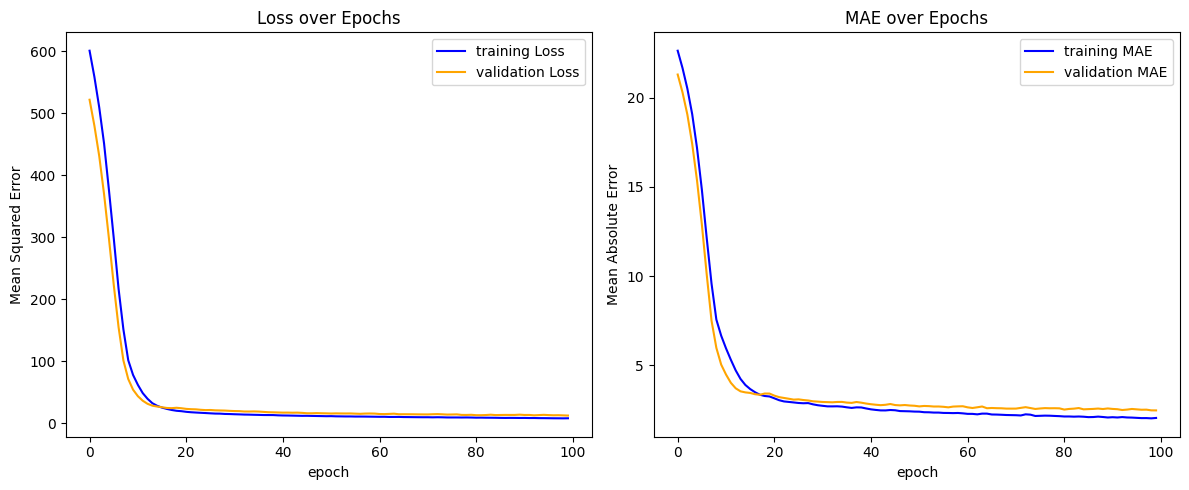

In [22]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training Loss', color='blue')
plt.plot(history.history['val_loss'], label='validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plotting the MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='training MAE', color='blue')
plt.plot(history.history['val_mae'], label='validation MAE', color='orange')
plt.title('MAE over Epochs')
plt.xlabel('epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


You can see in the visualizations above in the first 20 epochs there is a large decrease in both MSE and MAE. After around 20 epochs we still see some increases but they are minimal. We could assume that if we added Epochs, say 1000, we would still be seeing gradual improvements in both these but not significant.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


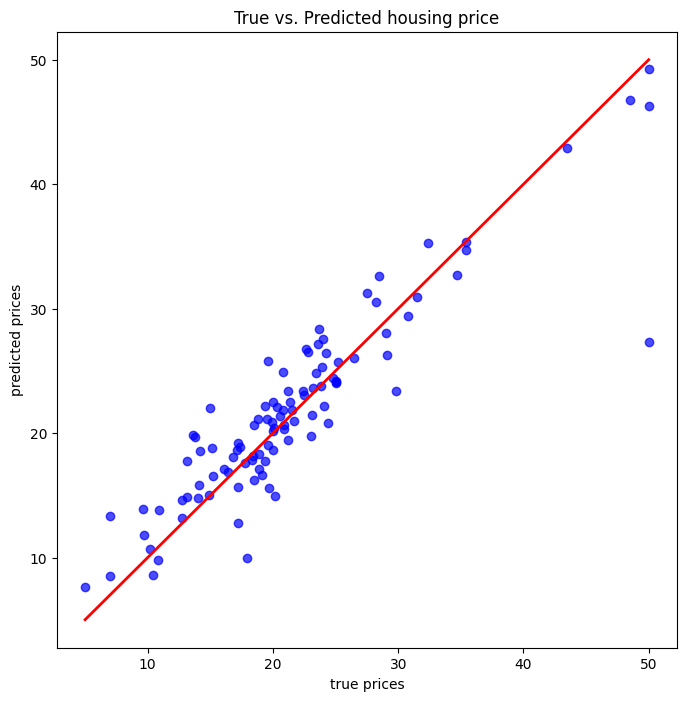

In [24]:
# Predictions
y_pred = model.predict(X_test_final)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('True vs. Predicted housing price')
plt.xlabel('true prices')
plt.ylabel('predicted prices')
plt.show()


The above red line is our predicted price. Our predictions do seem to be good at making the predictions.

### Testing Scaling
Output without Scaling AdamW:
- Test Loss: 25.2093, Test MAE: 3.8462
- Test R^2: 0.6562

Output without Scaling outliers Adam:
- Test Loss: 24.4011, Test MAE: 3.8088
- Test R^2: 0.6673

Output with Standard Scaling AdamW:
- Test Loss: 12.7816, Test MAE: 2.3946
- Test R^2: 0.8257

Output with Standard Scaling outliers Adam:
- Test Loss: 12.4331, Test MAE: 2.3684
- Test R^2: 0.8305

### Testing with and without Outliers

Output without removing outliers AdamW:
- Test Loss: 26.2893, Test MAE: 3.8368
- Test R^2: 0.6415

Output without removing outliers Adam:
- Test Loss: 24.8915, Test MAE: 3.7672
- Test R^2: 0.6220

Removing Outliers AdamW:
- Test Loss: 24.9030, Test MAE: 3.4792
- Test R^2: 0.4931

Removing Outliers Adam:
- Test Loss: 28.4736, Test MAE: 3.8015
- Test R^2: 0.4204

Leaving the outliers in the dataset seems to actually help the model capture more of the variablitly within the housing prices.

### Testing SOM size
 
10 x 10 SOM
- Test Loss: 12.9670, Test MAE: 2.3397
- Test R^2: 0.8232

15 x 15 SOM:
- Test Loss: 12.0309, Test MAE: 2.4068
- Test R^2: 0.8359

7 x 7 SOM:
- Test Loss: 11.9439, Test MAE: 2.2404
- Test R^2: 0.8371


# OVERVIEW

### Goal of Project
The goal of this the median housing price (MEDV) for each tract in the Boston Housing Dataset by combining two DL models. First we used SOM (Self Organizing Map) to find hidden groupings in the census tracts and then we use a ANN to do supervised regression. The hope is that the SOM will be able to captue some of the patterns and segment the data into groups. Then when the cluster labels are provided to the ANN extra feature it will help the ANN predict.

### Steps of project:
- Step 1 - Data Processing: This was the first step, to load, clean, split and scale the data.
- Step 2 - SOM Implementation: We used a 7x7 SOM which is trained on the data. The SOM maps data onto a 2D grid of Neurons. Each neuron learning a codebook vector that represents a portion of the dataset. Kmeans was used to group the SOM codebook vectors to grouped neurons into smaller clusters. This was to help summarize the structure of the SOM. Each data point was assigned a cluster label by BMU. The cluster labels were then one-hot-encoded and combined with the original features.
- Step 3 - ANN Implementation: the labels were then fed into the ANN. The ANN is made with dense layers (HOW MANY!!) that utilize the relu activation function, and then a linear output layer to predict the housing pricess in each tract. 

**Outputs:**
The best outputs we got were using the standard scaling outliers with Adam activation and a 7x7 SOM:
- Test Loss: 12.4331, Test MAE: 2.3684
- Test R^2: 0.8305

### Two model effects on Project:
Combining the SOM and the ANN seemed to work well in combination adding additional insight to the predictions. While the overall effect of the SOM in this case seemed to be minimal with a larger dataset, more complex data, or further parameter tuning this could have made larger impacts on the overall predictions made by the ANN. In our case increasing the SOM size does not have a massive affect on the output R-squared. This may mean that the SOM implementation may have little to no effect on predicting the price as the groupings are already well defined within the data itself.

Resources:

- https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset
- https://chatgpt.com/
- 